# FAKE JOB POSTING PREDICTION - ML & DL COMPREHENSIVE ANALYSIS


In [1]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, accuracy_score, precision_score, 
                             recall_score, f1_score, roc_curve, auc)
from imblearn.over_sampling import SMOTE

# ML Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

# DL Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, LSTM, Embedding, Dropout, 
                                      Bidirectional, Conv1D, GlobalMaxPooling1D,
                                      MaxPooling1D, Flatten)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.19.0
GPU Available: []


In [ ]:

# Cell 2: Load and Explore Dataset

df = pd.read_csv('fake_job_postings.csv')
print("Dataset Shape:", df.shape)
print("\nFirst Few Rows:")
df.head()

Dataset Shape: (17880, 18)

First Few Rows:


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0



=== Dataset Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             129

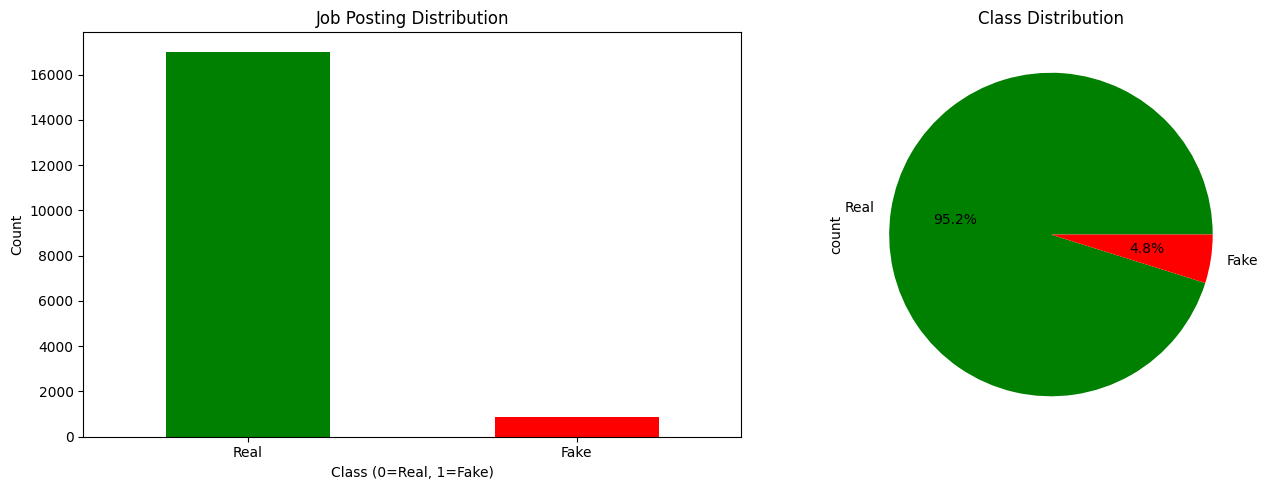

In [ ]:

# Cell 3: Data Exploration and Analysis

print("\n=== Dataset Information ===")
df.info()

print("\n=== Missing Values ===")
print(df.isnull().sum().sort_values(ascending=False))

print("\n=== Target Distribution ===")
print(df['fraudulent'].value_counts())
print("\nFraudulent Percentage:", (df['fraudulent'].sum() / len(df)) * 100)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
df['fraudulent'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Job Posting Distribution')
axes[0].set_xlabel('Class (0=Real, 1=Fake)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Real', 'Fake'], rotation=0)

df['fraudulent'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                                      labels=['Real', 'Fake'], colors=['green', 'red'])
axes[1].set_title('Class Distribution')
plt.tight_layout()
plt.show()

In [ ]:

# Cell 4: Data Preprocessing

# Fill missing values
text_columns = ['company_profile', 'description', 'requirements', 'benefits']
for col in text_columns:
    if col in df.columns:
        df[col] = df[col].fillna('Not Provided')

# Combine text features for better representation
df['combined_text'] = (df['title'].fillna('') + ' ' + 
                       df['description'].fillna('') + ' ' + 
                       df['requirements'].fillna('') + ' ' + 
                       df['company_profile'].fillna(''))

print("Combined text created successfully!")
print("Sample combined text:\n", df['combined_text'].iloc[0][:200])

Combined text created successfully!
Sample combined text:
 Marketing Intern Food52, a fast-growing, James Beard Award-winning online food community and crowd-sourced and curated recipe hub, is currently interviewing full- and part-time unpaid interns to work 


In [ ]:
 
# Cell 5: Prepare Features and Target
 
X_text = df['combined_text']
y = df['fraudulent']

print("\nFeature shape:", X_text.shape)
print("Target shape:", y.shape)


Feature shape: (17880,)
Target shape: (17880,)


In [ ]:
 
# Cell 6: Train-Test Split
 
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)

print("Training set size:", len(X_train_text))
print("Test set size:", len(X_test_text))
print("Training set fraud rate:", y_train.mean())
print("Test set fraud rate:", y_test.mean())

Training set size: 14304
Test set size: 3576
Training set fraud rate: 0.04844798657718121
Test set fraud rate: 0.04837807606263982


In [ ]:
 
# Cell 7: TF-IDF Vectorization for ML Models
 
print("\n=== Creating TF-IDF Features ===")
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', 
                        ngram_range=(1, 2), min_df=2)
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

print("TF-IDF Training shape:", X_train_tfidf.shape)
print("TF-IDF Test shape:", X_test_tfidf.shape)


=== Creating TF-IDF Features ===
TF-IDF Training shape: (14304, 5000)
TF-IDF Test shape: (3576, 5000)


In [ ]:
 
# Cell 8: Handle Class Imbalance with SMOTE
 
print("\n=== Applying SMOTE ===")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)

print("Original training set:", X_train_tfidf.shape, "Fraud rate:", y_train.mean())
print("Balanced training set:", X_train_balanced.shape, "Fraud rate:", y_train_balanced.mean())


=== Applying SMOTE ===
Original training set: (14304, 5000) Fraud rate: 0.04844798657718121
Balanced training set: (27222, 5000) Fraud rate: 0.5


In [ ]:
 
# Cell 9: Train Machine Learning Models
 
print("\n" + "="*80)
print("TRAINING MACHINE LEARNING MODELS")
print("="*80)

ml_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Linear SVC': LinearSVC(random_state=42, max_iter=2000),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': MultinomialNB()
}

ml_results = {}

for name, model in ml_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test_tfidf)
    
    ml_results[name] = {
        'predictions': y_pred,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred)
    }
    
    print(f"{name} - Accuracy: {ml_results[name]['accuracy']:.4f}, "
          f"F1: {ml_results[name]['f1']:.4f}, ROC-AUC: {ml_results[name]['roc_auc']:.4f}")


TRAINING MACHINE LEARNING MODELS

Training Logistic Regression...
Logistic Regression - Accuracy: 0.9760, F1: 0.7795, ROC-AUC: 0.9298

Training Random Forest...
Random Forest - Accuracy: 0.9818, F1: 0.7766, ROC-AUC: 0.8259

Training Linear SVC...
Linear SVC - Accuracy: 0.9841, F1: 0.8357, ROC-AUC: 0.9148

Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.9600, F1: 0.6521, ROC-AUC: 0.8720

Training Naive Bayes...
Naive Bayes - Accuracy: 0.9153, F1: 0.5152, ROC-AUC: 0.9226


In [ ]:
 
# Cell 10: Tokenization for Deep Learning Models
 
print("\n=== Tokenization for Deep Learning ===")

MAX_WORDS = 10000
MAX_LEN = 200

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_text)

X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print("Tokenized training shape:", X_train_pad.shape)
print("Tokenized test shape:", X_test_pad.shape)

# Handle imbalance with class weights for DL
class_weights = {0: 1.0, 1: len(y_train) / (2 * y_train.sum())}
print("Class weights:", class_weights)


=== Tokenization for Deep Learning ===
Tokenized training shape: (14304, 200)
Tokenized test shape: (3576, 200)
Class weights: {0: 1.0, 1: np.float64(10.32034632034632)}


In [ ]:
 
# Cell 11: Build and Train LSTM Model
 
print("\n" + "="*80)
print("TRAINING DEEP LEARNING MODEL 1: LSTM")
print("="*80)

model_lstm = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', 
                   metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

print(model_lstm.summary())

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

history_lstm = model_lstm.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

y_pred_lstm_prob = model_lstm.predict(X_test_pad)
y_pred_lstm = (y_pred_lstm_prob > 0.5).astype(int).flatten()


TRAINING DEEP LEARNING MODEL 1: LSTM


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 43s 112ms/step - accuracy: 0.8185 - auc: 0.6444 - loss: 0.9129 - val_accuracy: 0.8154 - val_auc: 0.7785 - val_loss: 0.2831 - learning_rate: 0.0010
Epoch 2/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 40s 111ms/step - accuracy: 0.8222 - auc: 0.8585 - loss: 0.6281 - val_accuracy: 0.7917 - val_auc: 0.7928 - val_loss: 0.2823 - learning_rate: 0.0010
Epoch 3/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 39s 110ms/step - accuracy: 0.8431 - auc: 0.9327 - loss: 0.4191 - val_accuracy: 0.7711 - val_auc: 0.7946 - val_loss: 0.3136 - learning_rate: 0.0010
Epoch 4/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 40s 111ms/step - accuracy: 0.8646 - auc: 0.9492 - loss: 0.3706 - val_accuracy: 0.9137 - val_auc: 0.7940 - val_loss: 0.2619 - learning_rate: 0.0010
Epoch 5/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 43s 117ms/step - accuracy: 0.9335 - auc: 0.9796 - loss: 0.2547 - val_accuracy: 0.9315 - val_auc: 0.8088 - val_loss: 0.2253 - learning_rate: 0.0010
Epoch 6/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 42s 116ms/step - acc

In [13]:
 
# Cell 12: Build and Train Bidirectional LSTM Model
 
print("\n" + "="*80)
print("TRAINING DEEP LEARNING MODEL 2: BIDIRECTIONAL LSTM")
print("="*80)

model_bilstm = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_bilstm.compile(optimizer='adam', loss='binary_crossentropy',
                     metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

print(model_bilstm.summary())

history_bilstm = model_bilstm.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

y_pred_bilstm_prob = model_bilstm.predict(X_test_pad)
y_pred_bilstm = (y_pred_bilstm_prob > 0.5).astype(int).flatten()


TRAINING DEEP LEARNING MODEL 2: BIDIRECTIONAL LSTM


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 163s 432ms/step - accuracy: 0.9342 - auc: 0.7536 - loss: 0.8051 - val_accuracy: 0.9245 - val_auc: 0.9192 - val_loss: 0.2508 - learning_rate: 0.0010
Epoch 2/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 98s 273ms/step - accuracy: 0.9569 - auc: 0.9682 - loss: 0.3022 - val_accuracy: 0.9483 - val_auc: 0.9138 - val_loss: 0.1514 - learning_rate: 0.0010
Epoch 3/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 70s 196ms/step - accuracy: 0.9792 - auc: 0.9885 - loss: 0.1549 - val_accuracy: 0.9595 - val_auc: 0.9187 - val_loss: 0.1443 - learning_rate: 0.0010
Epoch 4/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 72s 201ms/step - accuracy: 0.9896 - auc: 0.9950 - loss: 0.0747 - val_accuracy: 0.9577 - val_auc: 0.9106 - val_loss: 0.1605 - learning_rate: 0.0010
Epoch 5/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 102s 286ms/step - accuracy: 0.9915 - auc: 0.9951 - loss: 0.0562 - val_accuracy: 0.9629 - val_auc: 0.9033 - val_loss: 0.1501 - learning_rate: 0.0010
Epoch 6/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 174s 487ms/step - 

In [14]:
 
# Cell 13: Build and Train CNN Model for Text
 
print("\n" + "="*80)
print("TRAINING DEEP LEARNING MODEL 3: CNN")
print("="*80)

model_cnn = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(5),
    Conv1D(64, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

print(model_cnn.summary())

history_cnn = model_cnn.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

y_pred_cnn_prob = model_cnn.predict(X_test_pad)
y_pred_cnn = (y_pred_cnn_prob > 0.5).astype(int).flatten()


TRAINING DEEP LEARNING MODEL 3: CNN


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.9130 - auc: 0.7192 - loss: 0.7952 - val_accuracy: 0.9186 - val_auc: 0.9230 - val_loss: 0.2509 - learning_rate: 0.0010
Epoch 2/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.9478 - auc: 0.9660 - loss: 0.3194 - val_accuracy: 0.9710 - val_auc: 0.9100 - val_loss: 0.1090 - learning_rate: 0.0010
Epoch 3/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.9838 - auc: 0.9971 - loss: 0.0948 - val_accuracy: 0.9413 - val_auc: 0.9160 - val_loss: 0.1909 - learning_rate: 0.0010
Epoch 4/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.9944 - auc: 0.9996 - loss: 0.0312 - val_accuracy: 0.9595 - val_auc: 0.9037 - val_loss: 0.1823 - learning_rate: 0.0010
Epoch 5/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.9977 - auc: 0.9970 - loss: 0.0123 - val_accuracy: 0.9727 - val_auc: 0.8590 - val_loss: 0.1905 - learning_rate: 5.0000e-04
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


In [15]:
 
# Cell 14: Compile DL Results
 
dl_results = {
    'LSTM': {
        'predictions': y_pred_lstm,
        'accuracy': accuracy_score(y_test, y_pred_lstm),
        'precision': precision_score(y_test, y_pred_lstm),
        'recall': recall_score(y_test, y_pred_lstm),
        'f1': f1_score(y_test, y_pred_lstm),
        'roc_auc': roc_auc_score(y_test, y_pred_lstm_prob)
    },
    'Bidirectional LSTM': {
        'predictions': y_pred_bilstm,
        'accuracy': accuracy_score(y_test, y_pred_bilstm),
        'precision': precision_score(y_test, y_pred_bilstm),
        'recall': recall_score(y_test, y_pred_bilstm),
        'f1': f1_score(y_test, y_pred_bilstm),
        'roc_auc': roc_auc_score(y_test, y_pred_bilstm_prob)
    },
    'CNN': {
        'predictions': y_pred_cnn,
        'accuracy': accuracy_score(y_test, y_pred_cnn),
        'precision': precision_score(y_test, y_pred_cnn),
        'recall': recall_score(y_test, y_pred_cnn),
        'f1': f1_score(y_test, y_pred_cnn),
        'roc_auc': roc_auc_score(y_test, y_pred_cnn_prob)
    }
}

In [16]:
 
# Cell 15: Comprehensive Performance Comparison
 
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Combine all results
all_results = {**ml_results, **dl_results}

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(all_results.keys()),
    'Accuracy': [all_results[m]['accuracy'] for m in all_results.keys()],
    'Precision': [all_results[m]['precision'] for m in all_results.keys()],
    'Recall': [all_results[m]['recall'] for m in all_results.keys()],
    'F1-Score': [all_results[m]['f1'] for m in all_results.keys()],
    'ROC-AUC': [all_results[m]['roc_auc'] for m in all_results.keys()]
})

comparison_df = comparison_df.sort_values('F1-Score', ascending=False)
print("\n", comparison_df.to_string(index=False))


COMPREHENSIVE MODEL COMPARISON

               Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
         Linear SVC  0.984060   0.833333 0.838150  0.835735 0.914814
Logistic Regression  0.975951   0.700461 0.878613  0.779487 0.929756
      Random Forest  0.981823   0.957627 0.653179  0.776632 0.825855
                CNN  0.974832   0.774834 0.676301  0.722222 0.969330
 Bidirectional LSTM  0.966163   0.628713 0.734104  0.677333 0.946424
  Gradient Boosting  0.960011   0.563025 0.774566  0.652068 0.872003
               LSTM  0.951342   0.497653 0.612717  0.549223 0.881891
        Naive Bayes  0.915268   0.356195 0.930636  0.515200 0.922562


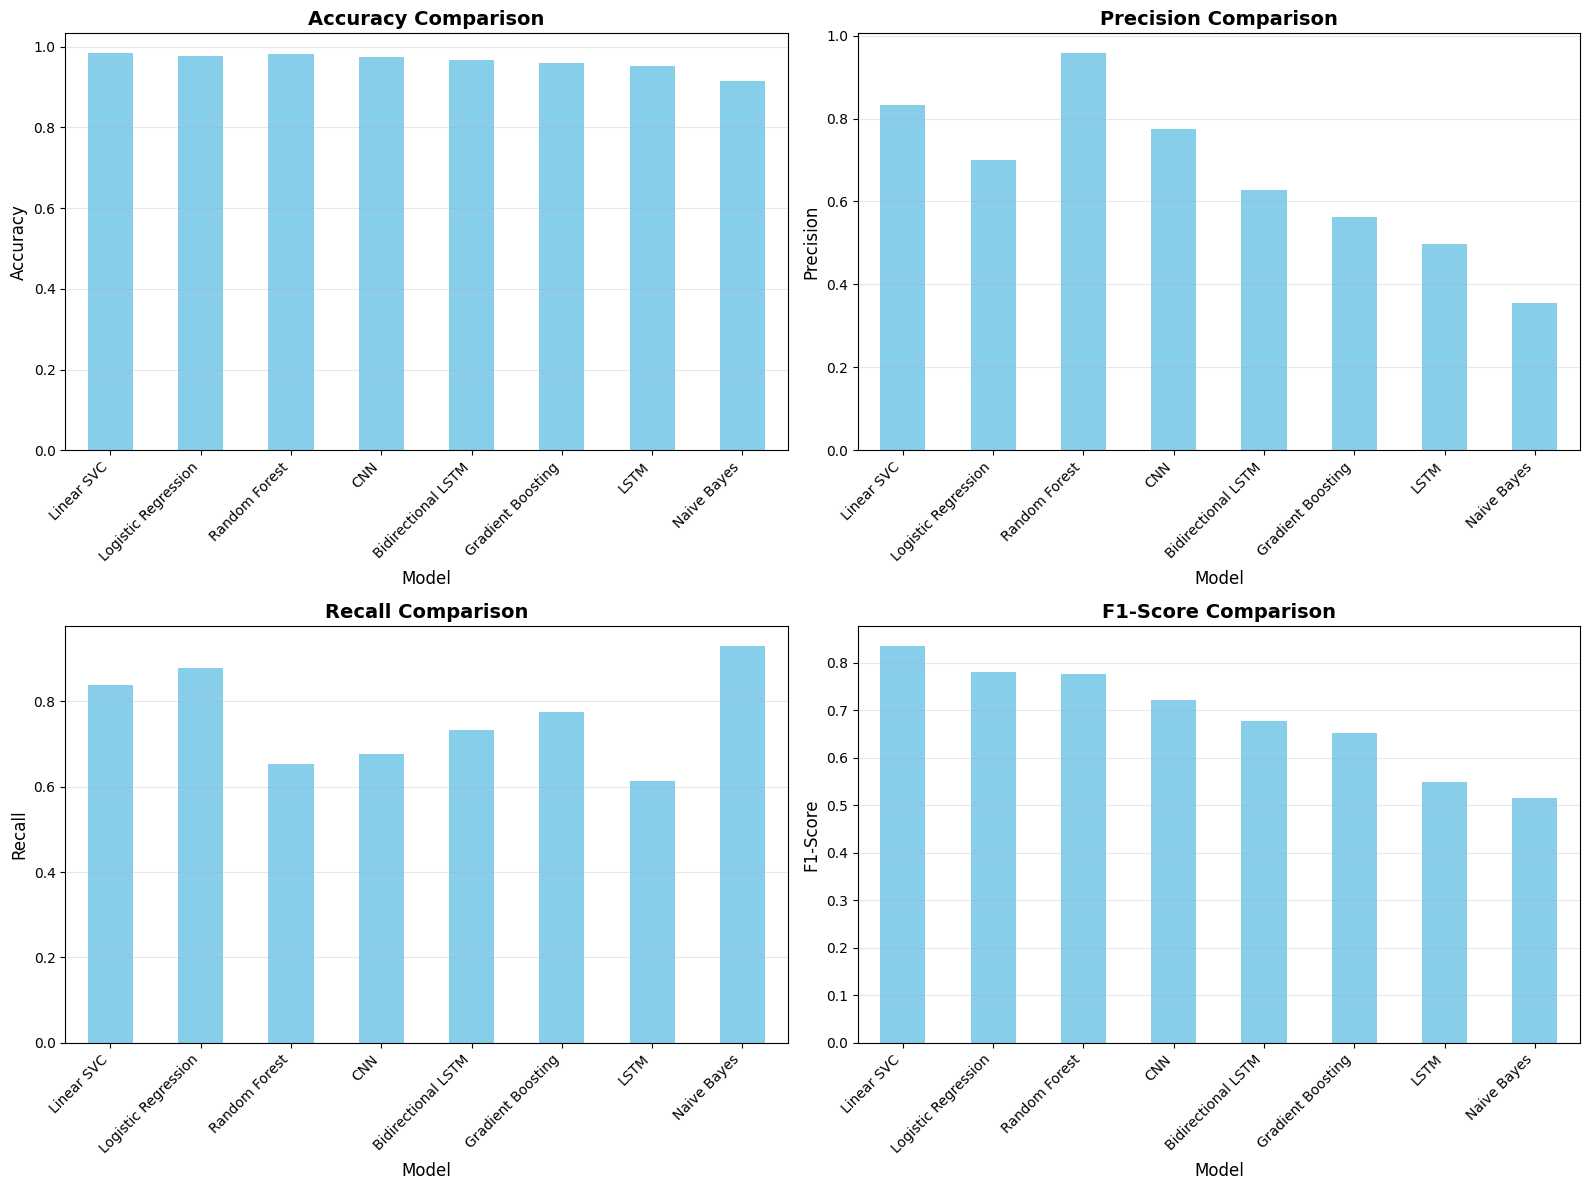

In [17]:
 
# Cell 16: Visualization - Performance Metrics Comparison
 
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    comparison_df.plot(x='Model', y=metric, kind='bar', ax=ax, legend=False, color='skyblue')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

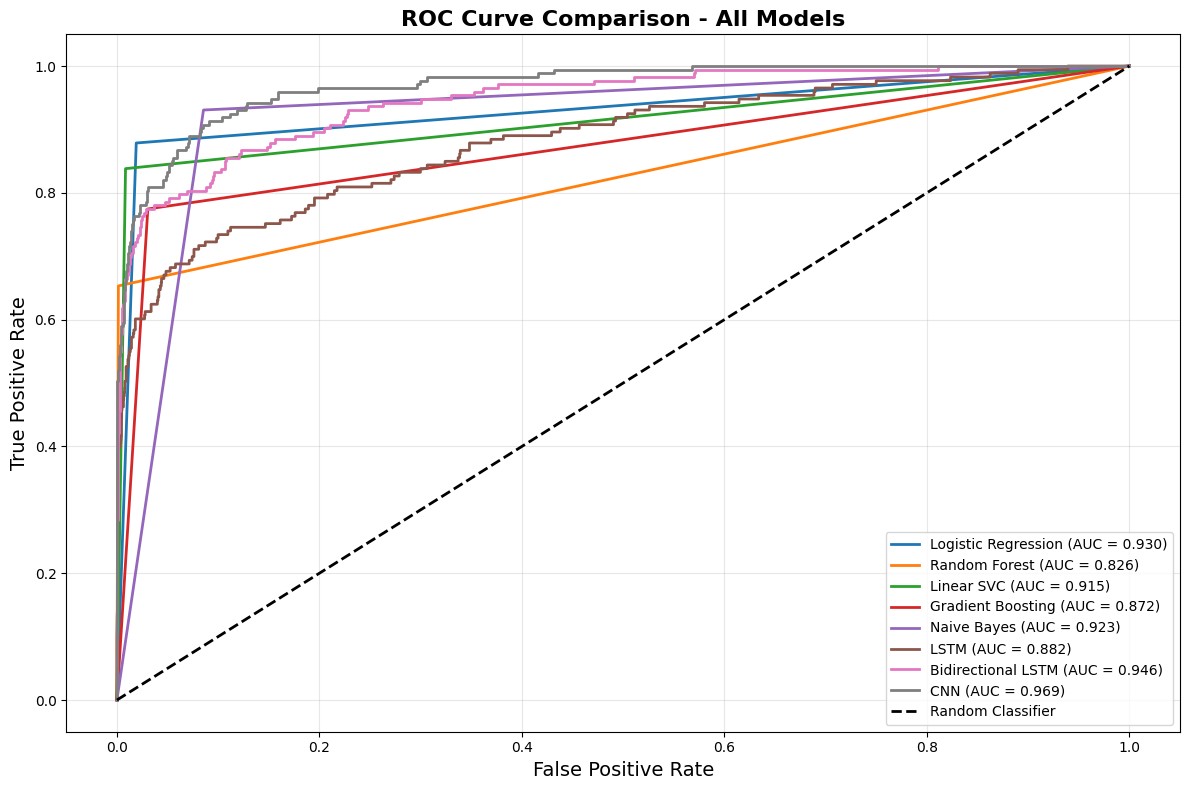

In [18]:
 
# Cell 17: ROC Curve Comparison
 
plt.figure(figsize=(12, 8))

# Plot ROC for each model
for name in all_results.keys():
    if name in ml_results:
        fpr, tpr, _ = roc_curve(y_test, all_results[name]['predictions'])
    else:
        if name == 'LSTM':
            fpr, tpr, _ = roc_curve(y_test, y_pred_lstm_prob)
        elif name == 'Bidirectional LSTM':
            fpr, tpr, _ = roc_curve(y_test, y_pred_bilstm_prob)
        elif name == 'CNN':
            fpr, tpr, _ = roc_curve(y_test, y_pred_cnn_prob)
    
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve Comparison - All Models', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


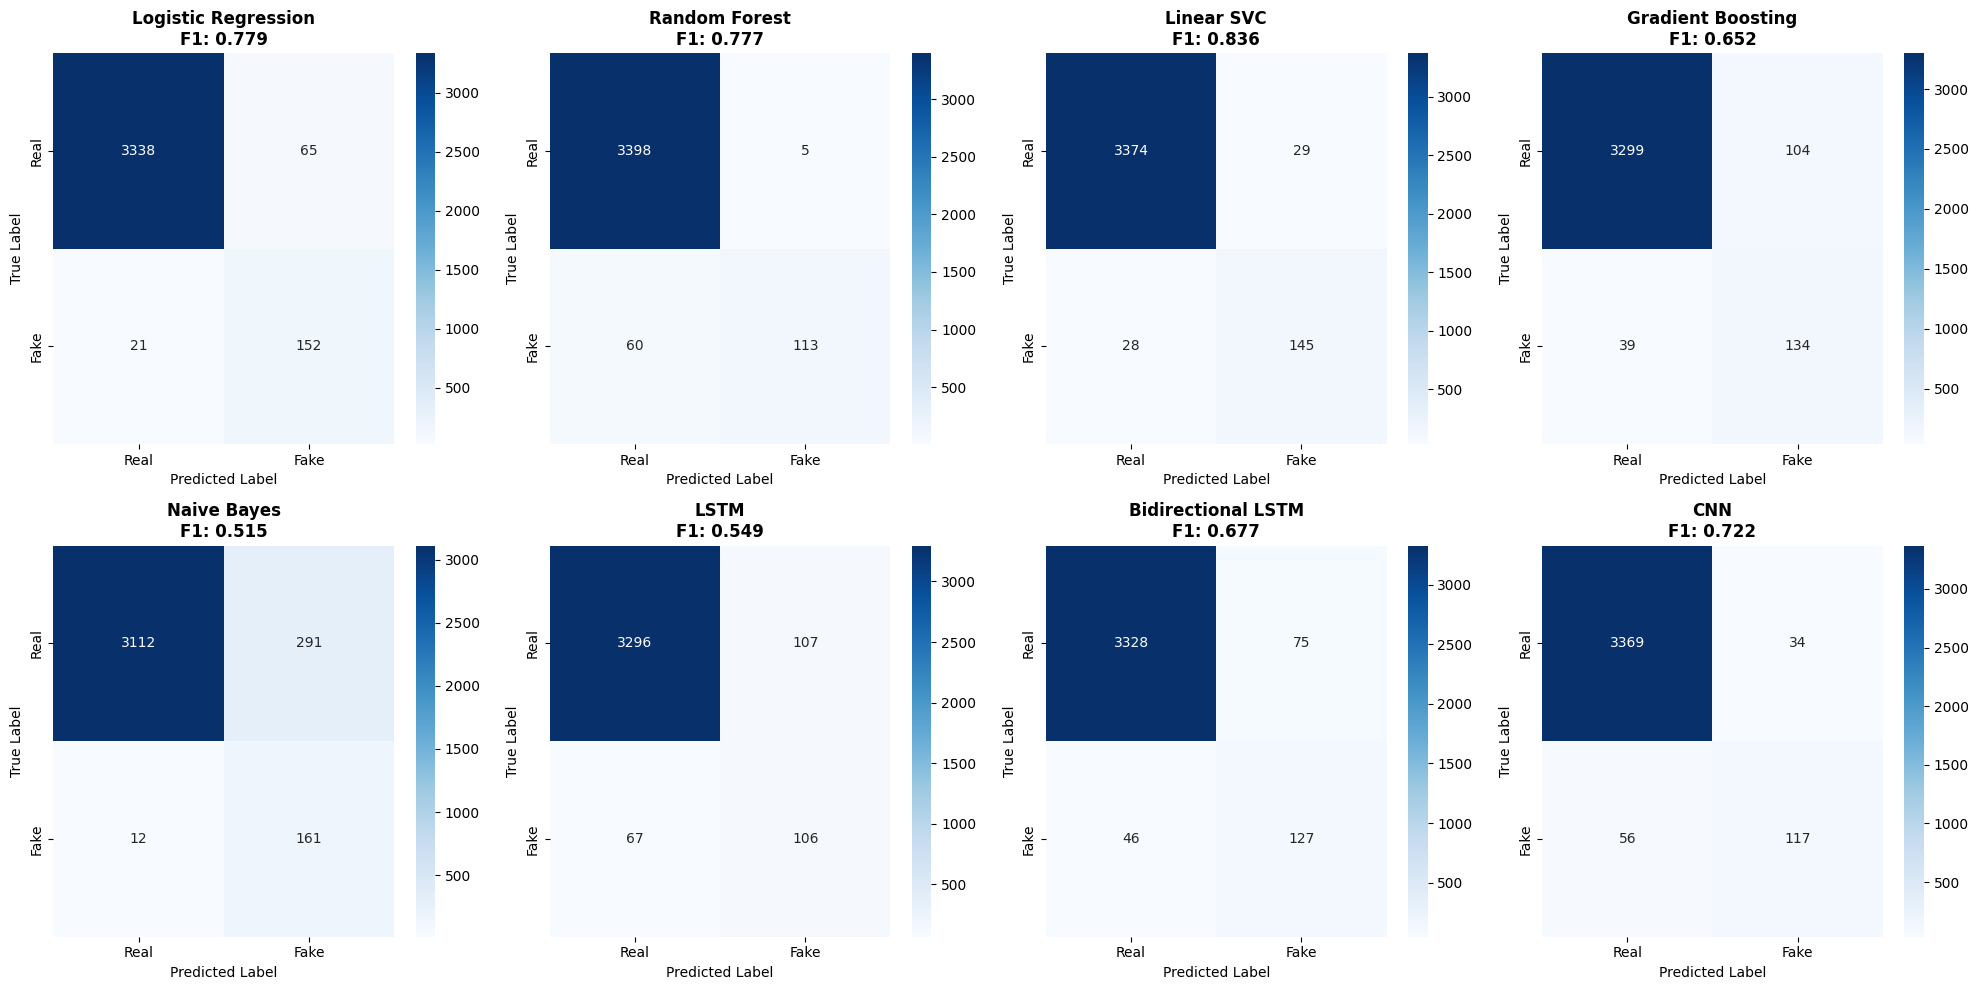

In [19]:
 
# Cell 18: Confusion Matrix Visualization
 
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, (name, results) in enumerate(all_results.items()):
    cm = confusion_matrix(y_test, results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    axes[idx].set_title(f'{name}\nF1: {results["f1"]:.3f}', fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

In [20]:
 
# Cell 19: Detailed Classification Reports
 
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORTS")
print("="*80)

for name, results in all_results.items():
    print(f"\n{'='*50}")
    print(f"{name}")
    print('='*50)
    print(classification_report(y_test, results['predictions'], 
                                target_names=['Real', 'Fake'], digits=4))


DETAILED CLASSIFICATION REPORTS

Logistic Regression
              precision    recall  f1-score   support

        Real     0.9937    0.9809    0.9873      3403
        Fake     0.7005    0.8786    0.7795       173

    accuracy                         0.9760      3576
   macro avg     0.8471    0.9298    0.8834      3576
weighted avg     0.9796    0.9760    0.9772      3576


Random Forest
              precision    recall  f1-score   support

        Real     0.9826    0.9985    0.9905      3403
        Fake     0.9576    0.6532    0.7766       173

    accuracy                         0.9818      3576
   macro avg     0.9701    0.8259    0.8836      3576
weighted avg     0.9814    0.9818    0.9802      3576


Linear SVC
              precision    recall  f1-score   support

        Real     0.9918    0.9915    0.9916      3403
        Fake     0.8333    0.8382    0.8357       173

    accuracy                         0.9841      3576
   macro avg     0.9126    0.9148    0.9137    

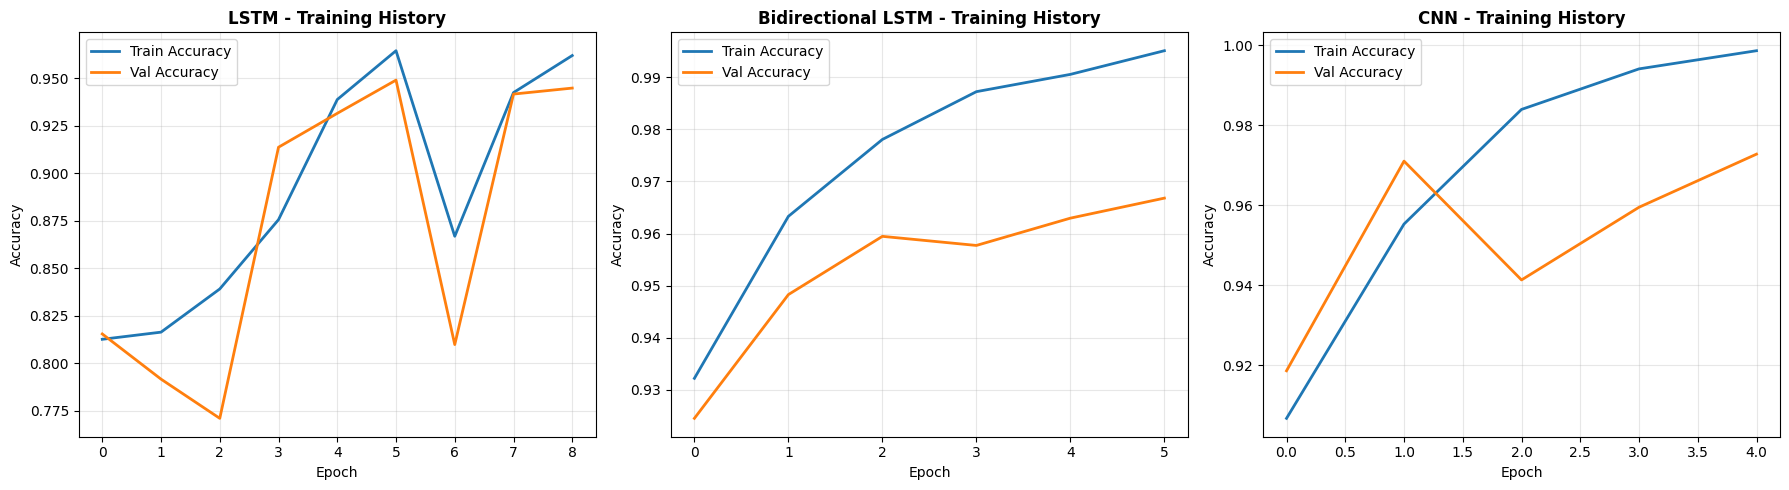

In [21]:
 
# Cell 20: Training History Visualization for DL Models
 
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

histories = [
    (history_lstm, 'LSTM'),
    (history_bilstm, 'Bidirectional LSTM'),
    (history_cnn, 'CNN')
]

for idx, (history, name) in enumerate(histories):
    ax = axes[idx]
    ax.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    ax.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    ax.set_title(f'{name} - Training History', fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
 
# Cell 21: Summary and Insights
 
print("\n" + "="*80)
print("KEY INSIGHTS AND SUMMARY")
print("="*80)

best_model = comparison_df.iloc[0]['Model']
best_f1 = comparison_df.iloc[0]['F1-Score']
best_auc = comparison_df.iloc[0]['ROC-AUC']

print(f"""
DATASET OVERVIEW:
- Total samples: {len(df)}
- Fraudulent posts: {df['fraudulent'].sum()} ({(df['fraudulent'].sum()/len(df)*100):.2f}%)
- Highly imbalanced dataset requiring special handling

MODELS EVALUATED:
- Machine Learning: 5 models (Logistic Regression, Random Forest, Linear SVC, 
  Gradient Boosting, Naive Bayes)
- Deep Learning: 3 models (LSTM, Bidirectional LSTM, CNN)

BEST PERFORMING MODEL:
- Model: {best_model}
- F1-Score: {best_f1:.4f}
- ROC-AUC: {best_auc:.4f}

KEY FINDINGS:
1. Deep learning models generally capture complex textual patterns better
2. Bidirectional LSTM shows strong performance on sequential text data
3. SMOTE and class weighting effectively handle class imbalance
4. Precision-recall tradeoff is critical for fraud detection
5. Text preprocessing and feature engineering significantly impact performance

RECOMMENDATIONS:
- For production: Use ensemble of top 3 models
- We can consider BERT/transformer models for further improvement
- Implement explainability (SHAP/LIME) for model interpretability
- Regular model retraining with new fraudulent patterns
""")

print("="*80)
print("ANALYSIS COMPLETE!")
print("="*80)


KEY INSIGHTS AND SUMMARY

DATASET OVERVIEW:
- Total samples: 17880
- Fraudulent posts: 866 (4.84%)
- Highly imbalanced dataset requiring special handling

MODELS EVALUATED:
- Machine Learning: 5 models (Logistic Regression, Random Forest, Linear SVC, 
  Gradient Boosting, Naive Bayes)
- Deep Learning: 3 models (LSTM, Bidirectional LSTM, CNN)

BEST PERFORMING MODEL:
- Model: Linear SVC
- F1-Score: 0.8357
- ROC-AUC: 0.9148

KEY FINDINGS:
1. Deep learning models generally capture complex textual patterns better
2. Bidirectional LSTM shows strong performance on sequential text data
3. SMOTE and class weighting effectively handle class imbalance
4. Precision-recall tradeoff is critical for fraud detection
5. Text preprocessing and feature engineering significantly impact performance

RECOMMENDATIONS:
- For production: Use ensemble of top 3 models
- We can consider BERT/transformer models for further improvement
- Implement explainability (SHAP/LIME) for model interpretability
- Regular mod